# Classifying Doctor's Note by Category of Ejection Fraction Measurement

## Dependencies

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn # for oversampling and undersampling

from sklearn.naive_bayes import MultinomialNB
from create_training_set import create_data
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#from sklearn import decomposition
#from scipy import linalg
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Import Data

In [2]:
start = time.time()
df = create_data()
end = time.time()
print("Time elapsed: ", end-start)

Do you wish to save to csv? Y/N:  N


Operation complete.  Quitting.
Time elapsed:  60.79745554924011


## Preprocessing

In [3]:
# Relabel Method from strings to a numerical representation (0 for 2d, 1 for 3d, and 2 for None)
df['METHOD'] = df['METHOD'].astype('category')
df['METHOD'] = df['METHOD'].cat.rename_categories({'2d simpson biplane': 0, '3d imaging': 1, 'None': 2})

In [4]:
# Cut the set down to just the cleaned Note Text and to the Label
df_copy = df # copy
df = df[['NOTE_CLEAN', 'METHOD']]
# Separate out the labels 
labels = np.array(df['METHOD'])
print("Shape of label vector: ", labels.shape)
print("Type: ", type(labels))

Shape of label vector:  (5056,)
Type:  <class 'numpy.ndarray'>


In [5]:
# Convert the features into a document term matrix

# Word Counts
# vectorizer = CountVectorizer(stop_words='english') #, tokenizer=LemmaTokenizer())
# vectors = vectorizer.fit_transform(df['NOTE_CLEAN']).todense()

# TF-IDF
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(df['NOTE_CLEAN']).todense() # (documents, vocab)

print("Shape of document term matrix: ", vectors_tfidf.shape)
print("Type: ", type(vectors_tfidf))

Shape of document term matrix:  (5056, 3478)
Type:  <class 'numpy.matrix'>


In [6]:
vocab = np.array(vectorizer_tfidf.get_feature_names())

In [7]:
vocab[100:120]

array(['109', '10cm²', '10mm', '10mmhg', '10x', '11', '110', '111',
       '1110', '1114', '112', '112020', '1132', '114', '115', '1153',
       '1155', '116', '118', '119'], dtype='<U19')

In [8]:
df['METHOD'].describe()
target = np.array(df['METHOD'])

## Multinomial NBC

In [9]:
X_train, X_test, y_train, y_test = train_test_split(vectors_tfidf, target)

In [10]:
clf = MultinomialNB().fit(X_train, y_train)

In [11]:
# make predictions
yhat = clf.predict(X_test)
# evaluate predictions
acc = accuracy_score(y_test, yhat)
prec = precision_score(y_test, yhat, average='micro')
rec = recall_score(y_test, yhat, average='micro')
f1 = f1_score(y_test, yhat, average='micro')
print('Accuracy: %.3f' % acc)
print('Precision: %.3f' % prec)
print('Recall: %.3f' % rec)
print('F1 Score: %.3f' % f1)

Accuracy: 0.928
Precision: 0.928
Recall: 0.928
F1 Score: 0.928


Text(0.5, 1.0, 'Confusion Matrix')

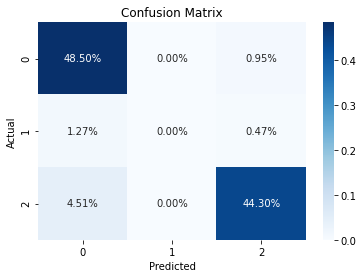

In [12]:
cm = confusion_matrix(y_test, yhat)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

__Analysis__: The results show that we can use a classification algorithm to sort documents according to our defined categories of Ejection Fraction Measurement Methods.  We can do this with remarkable accuracy, according to the metrics.  However, upon examining the confusion matrix, it appears clear that are algorithm excels at correctly classify 2D Simpson Biplane documents (0) and None documents (2), but not 3D Imaging (1).  

Examining a barplot of the counts of each methods tells us why.  There is a severe class imbalance, and so we'll need to change our sampling method to adjust for this.  

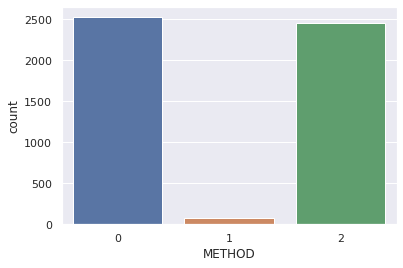

In [13]:
sns.set()
sns.countplot(x='METHOD', data=df)

### Re-sampling to compensate for class imbalance 

I will attempt to oversample Class 1, 3D Imaging, to a threshold of 50% of the training set.  I'll then try and undersample the other classes so that they're more or less present in equal proportions.  I was originally going to just oversample the minority class, but the barplot of the entire distribution of classes has me concerned that relying on oversampling alone would create an overfit model that wouldn't be useful as an applicable tool in the future.  Even so, oversampling the minority class to 50% might still result in overfitting, so I may have to play with the proportions.  

It may still be useful to try a straightforward oversampling anyway, just to compare results.  I might even be surprised.  

__Undersample Majority Classes__ 

Undersample Classes 0 and 2 to 1000 samples. 

In [14]:
# Define undersampling strategy
undersample = imblearn.under_sampling.RandomUnderSampler(sampling_strategy={0: 1000, 2: 1000})
# Fit and apply the transform 
X_under, y_under = undersample.fit_resample(X_train, y_train)

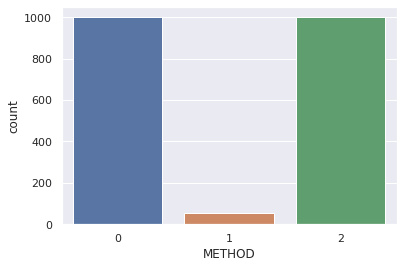

In [15]:
sns.countplot(x='METHOD', data = pd.DataFrame(y_under, columns=['METHOD']))

__Oversample Minority Class__ 

Oversample Class 1 to have the same number of samples as Classes 0 and 2 (1000 samples each).  

In [16]:
# Define oversample strategy 
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority') # oversample minority class
# Fit and apply the transform
X_over, y_over = oversample.fit_resample(X_under, y_under)

__Barplot of methods after re-sampling__

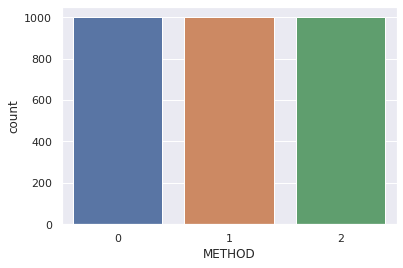

In [17]:
sns.countplot(x='METHOD', data = pd.DataFrame(y_over, columns=['METHOD']))

__Create a new classifier with the resampled data__

In [18]:
clf = MultinomialNB().fit(X_over, y_over)

In [19]:
# make predictions
yhat = clf.predict(X_test)
# evaluate predictions
acc = accuracy_score(y_test, yhat)
prec = precision_score(y_test, yhat, average='micro')
rec = recall_score(y_test, yhat, average='micro')
f1 = f1_score(y_test, yhat, average='micro')
print('Accuracy: %.3f' % acc)
print('Precision: %.3f' % prec)
print('Recall: %.3f' % rec)
print('F1 Score: %.3f' % f1)

# Compute MSE to see how different things are 
mse = np.sum((y_test - yhat)**2)/len(y_test)
print("Mean Squared Error: %.4f" % mse)

Accuracy: 0.878
Precision: 0.878
Recall: 0.878
F1 Score: 0.878
Mean Squared Error: 0.2500


Text(0.5, 1.0, 'Confusion Matrix')

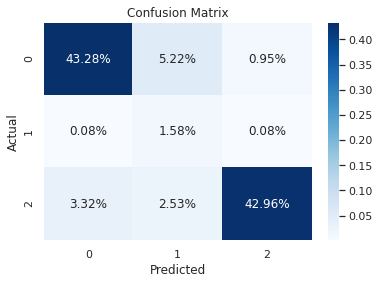

In [20]:
cm = confusion_matrix(y_test, yhat)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

__Analysis__ 

The good news is that according to the confusion matrix, we are now able to correctly classify some documents as "3D Imaging".  It's hard to tell how good we are at doing this, since so few examples of 3D Imaging exists.  One way to get a good idea of how close we are to accurately classifying documents that incorporated 3D Imaging as a measurement technique would be to look at the actual proportion of 3D Imaging documents in the original dataset.  If they are comparable, it's a good sign that we're on the right track.  

In [21]:
proportion_class1 = len(df['METHOD'] == 1)/ len(df['METHOD'])
print('Percentage of Class 1, 3D Imaging, in set: %.2f' % proportion_class1)

Percentage of Class 1, 3D Imaging, in set: 1.00


It looks like 3D Imaging only made up about 1% of the original data, which is comparable to the 1.03% we classified when using the test set.  Why is the percentage slightly higher?  If I had to guess, it is because the splits are random samples, so the actual proportion of observations aren't going to be necessarily the same as the whole set.  In other words, when the testing sample was created at the start, it could have had a slightly higher proportion of observations labeled as 3D Imaging than in the training sample, which would explain why the testing sample has a higher proportion of 3D Imaging observations than the parent sample.  

__Next Steps__ 

One thing I could try next would be to duplicate this process using other classification algorithms to compare and contrast performance.  Multinomial Logistic Regression, Decision Trees/Random Forests, or employing AdaBoost to increase performance.  I could even tinker with Neural Networks, although I am not sure the need justifies such a powerful tool.  

I should also run the model on samples and actually compare the output with the corresponding original text with my own eyes.  I'll need to write code to attach the predictions to a table of samples that includes the text and the classification labels.  

I would also like to try pickling the model and incorporating it into a Django application.  Incorporating it into an app would be great not just as an educational activity, but it could also turn it into a useable tool for others at HHC.  

It may also be useful to apply the lessons I have learned here to create a binary classifier for documents that are focused on ejection fration and documents that are not.  Conceivably, the two models could work together in a sort of pipeline.  First, we sort documents by mention of ejection fraction.  Then, among the documents remaining, we label according to measurement method.  Isolating the measurement alone would still require some hardcoded pattern matching relying on some combination of SpaCy, NLTK, and/or regex. 

## Applying resulting readable labels to the dataframe 

The next step is to run the algorithm on an entire chunk of data, and then attach the predictions to something that resembles a final dataset that we would want an end user to receive.  It should contain a column for ID numbers, a column for the doctor's notes, and a column with the predicted method label.  In and of itself, this is not the final product.  We'll still need to implement a similar process for classifying ejection fraction documents alone and functionality to isolate the actual the measurement numbers.  I'm not too worried about those steps, since they largely build off of the work that will have been completed by then.  I wasn't sure at first whether I should even bother creating a binary classifier for ejection fraction documents in general, but after I've thought about it some more, I've realized that it's probably necessary.  Not every document that mentions ejection fraction has a measurement method associated with it, so just labeling documents as ejection fraction via the method classification system will result in a lot of mislabeled documents.  

In [22]:
# Create an approximation of the data we would feed into our final product
df_copy = df_copy[['ID', 'NOTE_CLEAN', 'METHOD']]

# Copy input data
X = vectors_tfidf

In [23]:
# Run model
predictions = clf.predict(X)
# Save an array of the actual labels
actual = np.array(df['METHOD'])

In [24]:
# Relabel
df_out = pd.concat([df_copy, pd.Series(predictions)], axis='columns')
df_out = df_out.rename(columns={'METHOD': 'ACTUAL', 0: 'PREDICTED'})

In [25]:
# Change categorizations from numbers to strings for predictions
df_out['PREDICTED'] = df_out['PREDICTED'].astype('category')
df_out['PREDICTED'] = df_out['PREDICTED'].cat.rename_categories({0: '2d simpson biplane', 1: '3d imaging', 2: 'None'})

In [26]:
# Change categorizations from numbers to strings for actual labels
df_out['ACTUAL'] = df_out['ACTUAL'].astype('category')
df_out['ACTUAL'] = df_out['ACTUAL'].cat.rename_categories({0: '2d simpson biplane', 1: '3d imaging', 2: 'None'})

From here, we can output the dataframe as a csv, or presumably do other things to it like store it in a database.  

In [27]:
# Compute metrics to see how well the model perfoms on the full sample
acc = accuracy_score(actual, predictions)
prec = precision_score(actual, predictions, average='micro')
rec = recall_score(actual, predictions, average='micro')
f1 = f1_score(actual, predictions, average='micro')
print('Accuracy: %.3f' % acc)
print('Precision: %.3f' % prec)
print('Recall: %.3f' % rec)
print('F1 Score: %.3f' % f1)

# Compute MSE to see how different things are 
mse = np.sum((actual - predictions)**2)/len(actual)
print("Mean Squared Error: %.4f" % mse)

Accuracy: 0.904
Precision: 0.904
Recall: 0.904
F1 Score: 0.904
Mean Squared Error: 0.2019


Text(0.5, 1.0, 'Confusion Matrix')

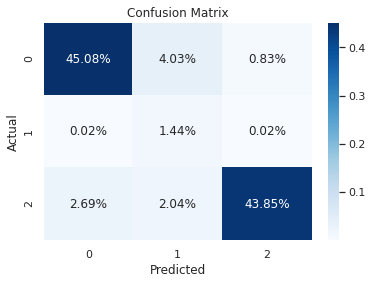

In [28]:
cm = confusion_matrix(actual, predictions)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

Metrics are similar, actually slightly better than the test.  That might be because we've trained the model specifically on a subset of this sample.  We'd probably get a more realistic simulation if we pulled an entirely new sample to run it on.  That being said, if the metrics are as good as an indicator as I think they are, this tool seems to have relatively high accuracy.  It's hard to say what standard is acceptable for actual production level use, but I think this is a positive sign.

## Saving model as pickle 

Use the Pickle Library to save the model and the vectorizer

In [29]:
import pickle

Dump the model to the ef_classifier.sav file, if it doesn't already exist.  It looks like we have to use the open() method to access it as the file argument for pickle.dump().  Within the open method, it looks like we're setting the mode arg to "wb", which I believe means we overwrite the file with binary information.  

https://docs.python.org/3/library/functions.html#open

In [30]:
pickle.dump(clf, open("ef_classifier.sav", "wb"))

Store the vectorizer object, which we want to use on the input data to transform it into something that the model can accept.  

In [31]:
pickle.dump(vectorizer_tfidf, open("vectorizer.sav", "wb"))